# Performance Evaluation

In [24]:
import os
from itertools import cycle
import ipympl

import pandas as pd
import matplotlib as mpl

# mpl.use('Agg')
# %matplotlib widget
%matplotlib inline

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib.ticker import AutoMinorLocator
from matplotlib import colors
import numpy as np
import seaborn as sb
from scipy import interpolate
from scipy.io import loadmat

import locale
# locale.setlocale(locale.LC_NUMERIC, "de_DE.UTF-8")
locale.setlocale(locale.LC_NUMERIC, "en_US.UTF-8")

# Use LaTex style
mpl.style.use('monitor')
mpl.style.use('custom-colors-swapped')

# FIGRATIO = 1.0/1.618 # Golden Ratio
# FIGRATIO = 1.0/np.sqrt(2) # DIN
FIGRATIO = 0.8
STD_MULT = 100

TEXTWIDTH = 314.403 / 72 # inches
FIGWIDTH = TEXTWIDTH
FIGWIDTH *= 3

# Get settings
methods = ['dans', 'cho', 'prop', 'bok']
methods_fullname = ['Dansereau et al.', 'Cho et al.', 'Proposed', 'Bok et al.']
methodsdict = dict([[method, name] for [method, name] in zip(methods, methods_fullname)])

# Read data file
folder = "/home/schambach/Documents/Paper/ML center detection, grid estimation and LF decoding/Code/Evaluation/"
csv_filename = "center_detection_measured_FULL_2019-10-29.csv"
df = pd.read_csv(os.path.join(folder, csv_filename))

# Correct float error in image distance 117mm
#df.loc[df['image_distance'] == 0.11699999999999999, 'image_distance'] = 0.117
df['image_distance'] = df['image_distance'].round(3)

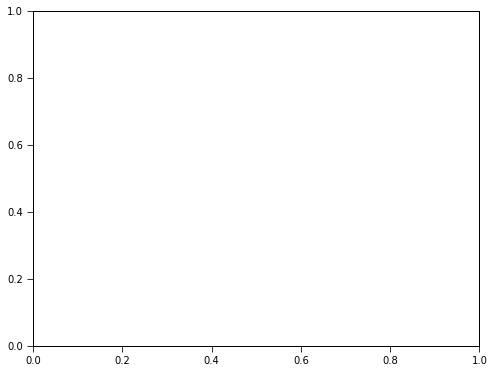

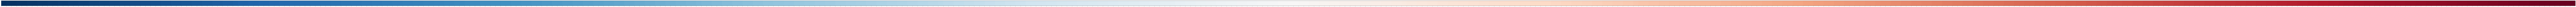

In [3]:
# Get colors from color cycle
fig, ax = plt.subplots()
color_cycle = ax._get_lines.prop_cycler

COLOR_1 = next(color_cycle)['color']
COLOR_2 = next(color_cycle)['color']
COLOR_3 = next(color_cycle)['color']

custom_cmap = colors.LinearSegmentedColormap.from_list("", [COLOR_1,"white", COLOR_3])
custom_cmap_red = colors.LinearSegmentedColormap.from_list("", ["white", COLOR_3])

sb.palplot(sb.color_palette("RdBu_r", 500))
sb_cmap = sb.color_palette("RdBu_r", 10_000)
sb_cmap_reds = sb.color_palette("Reds", 10_000)

## Evaluation

In [7]:
data_dans = df[(df['method'] == 'dans')]
data_cho = df[(df['method'] == 'cho')]
data_prop = df[(df['method'] == 'prop')]
data_bok = df[(df['method'] == 'bok')]

In [10]:
print("dans size: ", data_dans.shape)
print("prop size: ", data_cho.shape)
print("cho size: ", data_cho.shape)
print("bok size: ", data_bok.shape)

dans size:  (960, 13)
prop size:  (960, 13)
cho size:  (960, 13)
bok size:  (960, 13)


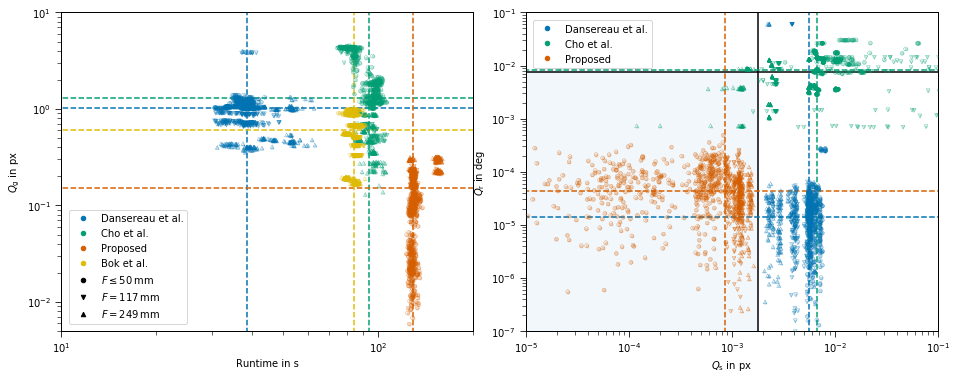

In [16]:
fig = plt.figure(figsize=(FIGWIDTH, (FIGRATIO-0.074)*FIGWIDTH))

ax1 = plt.subplot(221)
ax2 = plt.subplot(222)


linestyle = ['--']
line_cycle = cycle(linestyle)
markers = ['o', 'v', '^']

for method, name, index in zip(methods, methods_fullname, range(len(methods))):
    # Add plot legend label name
    color = next(ax1._get_lines.prop_cycler)['color']
    _ = ax1.plot(-1000, -1000, 'o', label=methodsdict[method], color=color)
    
    if not method=='bok':
        _ = ax2.plot(-1000, -1000, 'o', label=methodsdict[method], color=color)

    if method == 'cho':
        data_short = data_cho[data_cho['image_distance'] < 0.1]
        data_mid = data_cho[data_cho['image_distance'] == 0.117]
        data_long = data_cho[data_cho['image_distance'] == 0.249]
        data = data_cho
        zorder = 3

    elif method == 'dans':
        data_short = data_dans[data_dans['image_distance'] < 0.1]
        data_mid = data_dans[data_dans['image_distance'] == 0.117]
        data_long = data_dans[data_dans['image_distance'] == 0.249]
        data = data_dans
        zorder = 9

    elif method == 'prop':
        data_short = data_prop[data_prop['image_distance'] < 0.1]
        data_mid = data_prop[data_prop['image_distance'] == 0.117]
        data_long = data_prop[data_prop['image_distance'] == 0.249]
        data = data_prop
        zorder = 12

    elif method == 'bok':
        data_short = data_bok[data_bok['image_distance'] < 0.1]
        data_mid = data_bok[data_bok['image_distance'] == 0.117]
        data_long = data_bok[data_bok['image_distance'] == 0.249]
        data = data_bok
        zorder = 6
        
    _kwargs = {'s': 15,
               'label': None,
                'zorder': zorder,
                'color': color,
               'linewidth': 0,
               'alpha': 0.25}
    _kwargs_outline = {'s': 15,
                       'label': None,
                       'zorder': zorder,
                       'edgecolor': color,
                       'linewidth': 0.25,
                       'facecolor': 'None',
                       'alpha': 1}

    for tmp_data, tmp_marker in zip([data_short, data_mid, data_long], markers):
        ax1.scatter(tmp_data['runtime'], tmp_data['q_g'], marker=tmp_marker, **_kwargs)
        ax1.scatter(tmp_data['runtime'], tmp_data['q_g'], marker=tmp_marker, **_kwargs_outline)

        ax2.scatter(tmp_data['q_s'], tmp_data['q_r'], marker=tmp_marker, **_kwargs)
        ax2.scatter(tmp_data['q_s'], tmp_data['q_r'], marker=tmp_marker, **_kwargs_outline)


    # Plot mean values
    _kwargs = {'linestyle': next(line_cycle), 'color': color, 'linewidth': 1.5, 'label': None, 'zorder': 2}

    mean_q = data['q_g'].median()
    mean_runtime = data['runtime'].median()
    ax1.plot((mean_runtime, mean_runtime), (0, 10), **_kwargs)
    ax1.plot((0, 1000), (mean_q, mean_q), **_kwargs)

    mean_q_rot = data['q_r'].median()
    mean_q_spac = data['q_s'].median()
    ax2.plot((mean_q_spac, mean_q_spac), (0, 10), **_kwargs)
    ax2.plot((0, 1000), (mean_q_rot, mean_q_rot), **_kwargs)
        
        
# Draw Accuracy Requirement
_kwargs = {'linestyle': '-', 'color': 'black', 'linewidth': 1.5, 'label': None, 'zorder': 1}
q_r_req = 0.0074
q_s_req = 0.0018
ax2.plot((q_s_req, q_s_req), (0, 10), **_kwargs)
ax2.plot((0, 1000), (q_r_req, q_r_req), **_kwargs)

ax2.fill_between([0, q_s_req], [q_r_req, q_r_req], y2=0, color=COLOR_1, zorder=0, alpha=0.05)

# Set marker legend
for marker, markername in zip(markers, [r'$F \leq 50\,\rm{mm}$', r"$F = 117\,\rm{mm}$", r"$F = 249\,\rm{mm}$"]):
    _ = ax1.plot(-1000, -1000, marker, label=markername, color='black')

# Set labels
ax1.set_xlabel(r'Runtime in s')
ax1.set_ylabel(r'$Q_{\rm{g}}$ in px', labelpad=5)
ax2.set_xlabel(r'$Q_{\rm{s}}$ in px')
ax2.set_ylabel(r'$Q_{\rm{r}}$ in deg')

ax1.legend(loc='lower left')#, bbox_to_anchor=(0.5, +0.05),ncol=1)
ax2.legend(loc='upper left')

ax1.set_yscale('log')
ax1.set_xscale('log')
ax1.set_ylim(5e-3, 1e1)
ax1.set_xlim(1e1, 2e2)

ax2.set_xscale('log')
ax2.set_yscale('log')
ax2.set_ylim(1e-7, 1e-1)
ax2.set_xlim(1e-5, 1e-1)

fig.tight_layout(h_pad=0, w_pad=0, pad=0)
# fig.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.05, hspace=0.5)

# fig.savefig(os.path.join(FIG_FOLDER, "overall_comp.pdf"), bbox_inches='tight', pad_inches=0.01)
# fig.savefig(os.path.join(FIG_FOLDER, "overall_comp.pgf"), bbox_inches='tight', pad_inches=0.01)

## Correlation statistics
Investigate correlations for the different algorithms

In [18]:
corr_mat_dans = data_dans[['q_g', 'q_s', 'q_r', 'image_distance', 'grid_noise', 'img_noise', 'vignetting']].corr()
corr_mat_cho = data_cho[['q_g', 'q_s', 'q_r', 'image_distance', 'grid_noise', 'img_noise', 'vignetting']].corr()
corr_mat_prop = data_prop[['q_g', 'q_s', 'q_r', 'image_distance', 'grid_noise', 'img_noise','vignetting']].corr()
corr_mat_bok = data_bok[['q_g', 'q_s', 'q_r', 'image_distance', 'grid_noise', 'img_noise','vignetting']].corr()

corr_mat_prop

q_g       q_s       q_r  image_distance    grid_noise  \
q_g             1.000000  0.968881 -0.206216    8.877093e-01  1.056223e-02   
q_s             0.968881  1.000000 -0.186775    8.257032e-01  1.091912e-03   
q_r            -0.206216 -0.186775  1.000000   -2.829971e-01  1.475677e-01   
image_distance  0.887709  0.825703 -0.282997    1.000000e+00 -4.191527e-19   
grid_noise      0.010562  0.001092  0.147568   -4.191527e-19  1.000000e+00   
img_noise       0.029730  0.036859  0.170636    1.630244e-17 -6.856004e-17   
vignetting      0.073251  0.000280  0.251964    6.570945e-18 -3.540989e-19   

                   img_noise    vignetting  
q_g             2.973025e-02  7.325127e-02  
q_s             3.685901e-02  2.803846e-04  
q_r             1.706358e-01  2.519635e-01  
image_distance  1.630244e-17  6.570945e-18  
grid_noise     -6.856004e-17 -3.540989e-19  
img_noise       1.000000e+00  0.000000e+00  
vignetting      0.000000e+00  1.000000e+00

[Text(0.5, 0, '$F$'),
 Text(1.5, 0, '$\\sigma_{\\rm{g}}$'),
 Text(2.5, 0, '$\\sigma_{\\rm{n}}$'),
 Text(3.5, 0, 'vignetting')]

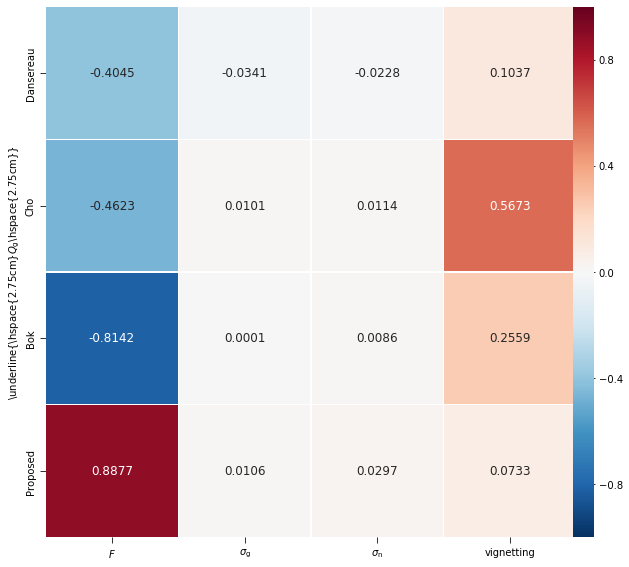

In [22]:
fig = plt.figure(figsize=(FIGWIDTH, (FIGRATIO-0.074)*FIGWIDTH))
ax = plt.subplot(111)

#Create Dataframe containing the correlations
_corr_select = pd.DataFrame(columns=['image_distance', 'grid_noise', 'img_noise', 'vignetting'],
                            index=['Dansereau', 'Cho', 'Bok', 'Proposed'],
                            dtype=np.float)

for data, name in zip([corr_mat_dans, corr_mat_cho, corr_mat_bok, corr_mat_prop], ['Dansereau', 'Cho', 'Bok', 'Proposed']):
    _corr_select.loc[name] = pd.to_numeric(data[['image_distance', 'grid_noise', 'img_noise', 'vignetting']].loc['q_g'])

ylabels = ['Dansereau', 'Cho', 'Bok',  'Proposed']
xlabels = [r'$F$', r'$\sigma_{\rm{g}}$', r'$\sigma_{\rm{n}}$', 'vignetting']

sb.heatmap(_corr_select, annot=True, square=True, vmin=-1.0, vmax=1.0,
           xticklabels=xlabels, yticklabels=ylabels,
           fmt=".4f", linewidths=.5, cmap=sb_cmap,
           ax=ax, cbar=True, cbar_kws=dict(shrink=1, pad=-0.005, aspect=25))

cbar = fig.get_axes()[1]
cbar.tick_params(direction='inout', size=1.5)

ax.set_ylabel(r'\underline{\hspace{2.75cm}$Q_{\rm{g}}$\hspace{2.75cm}}')
ax.set_yticklabels(ylabels, va='center', rotation=90, position=(0, 0))
ax.set_xticklabels(xlabels)

## Grid estimation tables

In [29]:
# Create emtpy table
cols = ['image_distance', 'grid_noise', 'q_g_ideal', 'q_g_dans', 'q_g_cho', 'q_g_bok', 'q_g_prop']
_table = pd.DataFrame(columns=cols, dtype=np.float)


# Fill columns
image_dist = [0.03, 0.047, 0.117, 0.249]

for i in range(len(image_dist)):    
        
    for sigma, j in zip([0, 0.1], [0, 1]):

        _table.loc[2*i+j] = np.nan
        
        for method in methods:

            data = df[(df['method']==method)]

            id = str("q_g_" + method)
            _table.loc[2*i+j]['image_distance'] = 1000 * image_dist[i]
            _table.loc[2*i+j]['grid_noise'] = sigma*10*0.0143
            _table.loc[2*i+j]['q_g_ideal'] = np.sqrt(2 / np.pi) * sigma
            _table.loc[2*i+j][id] = data[(data['grid_noise'] == sigma) & (data['image_distance'] == image_dist[i])]['q_g'].mean()

_table

image_distance  grid_noise  q_g_ideal  q_g_dans   q_g_cho   q_g_bok  \
0            30.0      0.0000   0.000000  1.200345  2.378058  0.917093   
1            30.0      0.0143   0.079788  1.200272  2.333272  0.917002   
2            47.0      0.0000   0.000000  1.033360  1.618889  0.671875   
3            47.0      0.0143   0.079788  1.033818  1.633063  0.672059   
4           117.0      0.0000   0.000000  0.874807  2.593443  0.415975   
5           117.0      0.0143   0.079788  0.848927  2.683066  0.416078   
6           249.0      0.0000   0.000000  0.757357  0.584178  0.306509   
7           249.0      0.0143   0.079788  0.667682  0.583800  0.306557   

   q_g_prop  
0  0.081074  
1  0.082873  
2  0.047558  
3  0.052931  
4  0.183926  
5  0.182723  
6  0.269213  
7  0.271158

In [31]:
print(_table.to_latex(columns=cols, index=False, formatters=[lambda x: '%10.0f' % x, lambda x: '%1.4f' % x, lambda x: '%1.4f' % x, lambda x: '%1.4f' % x, lambda x: '%1.4f' % x, lambda x: '%1.4f' % x, lambda x: '%1.4f' % x]))

\begin{tabular}{rrrrrrr}
\toprule
image\_distance & grid\_noise & q\_g\_ideal & q\_g\_dans & q\_g\_cho & q\_g\_bok & q\_g\_prop \\
\midrule
            30 &     0.0000 &    0.0000 &   1.2003 &  2.3781 &  0.9171 &   0.0811 \\
            30 &     0.0143 &    0.0798 &   1.2003 &  2.3333 &  0.9170 &   0.0829 \\
            47 &     0.0000 &    0.0000 &   1.0334 &  1.6189 &  0.6719 &   0.0476 \\
            47 &     0.0143 &    0.0798 &   1.0338 &  1.6331 &  0.6721 &   0.0529 \\
           117 &     0.0000 &    0.0000 &   0.8748 &  2.5934 &  0.4160 &   0.1839 \\
           117 &     0.0143 &    0.0798 &   0.8489 &  2.6831 &  0.4161 &   0.1827 \\
           249 &     0.0000 &    0.0000 &   0.7574 &  0.5842 &  0.3065 &   0.2692 \\
           249 &     0.0143 &    0.0798 &   0.6677 &  0.5838 &  0.3066 &   0.2712 \\
\bottomrule
\end{tabular}



## Decoding Evaluation
First, find WI that lies close to average performance in case of 30 mm lens

In [18]:
data_prop_30 = data_prop[data_prop['image_distance'] == 0.03]
avg = data_prop_30['q_g'].mean()
avg

0.08197336612771365

In [19]:
data_prop_30[np.abs(data_prop_30['q_g'] - avg) < 0.02]

id  image_distance                                offset  \
1925  dd98c9d7            0.03  [1.0934e-06, 1.4419999999999998e-07]   
1928  bc9d6833            0.03  [1.0934e-06, 1.4419999999999998e-07]   
1936  186a7408            0.03  [1.0934e-06, 1.4419999999999998e-07]   
1937  186a7408            0.03  [1.0934e-06, 1.4419999999999998e-07]   
1942  2e57ea58            0.03  [1.0934e-06, 1.4419999999999998e-07]   
1951  b79d3240            0.03   [2.814e-07, 4.7180000000000003e-07]   
1953  abfda1c7            0.03   [2.814e-07, 4.7180000000000003e-07]   
1960  4f514d69            0.03   [2.814e-07, 4.7180000000000003e-07]   
1965  192dcbaa            0.03   [2.814e-07, 4.7180000000000003e-07]   
1972  ed3359b1            0.03  [1.0934e-06, 1.4419999999999998e-07]   
1976  0d976955            0.03  [1.0934e-06, 1.4419999999999998e-07]   
1991  8cf4349c            0.03  [1.0934e-06, 1.4419999999999998e-07]   
1996  fb97e97e            0.03   [2.814e-07, 4.7180000000000003e-07]   
1997  fb97e97e            0.03   [2.814e-07, 4.7180000000000003e-07]   
2000  bd7de267            0.03   [2.814e-07, 4.7180000000000003e-07]   
2009  e84d18c1            0.03   [2.814e-07, 4.7180000000000003e-07]   
2011  e84d18c1            0.03   [2.814e-07, 4.7180000000000003e-07]   
2013  4bb91b00            0.03   [2.814e-07, 4.7180000000000003e-07]   
2023  0ab69729            0.03   [1.414e-07, 3.2899999999999994e-07]   
2032  a6af52fd            0.03   [1.414e-07, 3.2899999999999994e-07]   
2046  7443f14f            0.03                [9.912e-07, 5.642e-07]   
2049  58cf5efc            0.03                [9.912e-07, 5.642e-07]   
2061  534e1b82            0.03                [9.912e-07, 5.642e-07]   
2062  534e1b82            0.03                [9.912e-07, 5.642e-07]   
2073  c16de8d9            0.03   [1.414e-07, 3.2899999999999994e-07]   
2081  5deb69bf            0.03   [1.414e-07, 3.2899999999999994e-07]   
2085  af16bba3            0.03   [1.414e-07, 3.2899999999999994e-07]   
2093  f6cbb096            0.03                [9.912e-07, 5.642e-07]   
2094  f6cbb096            0.03                [9.912e-07, 5.642e-07]   
2099  c17fc67c            0.03                [9.912e-07, 5.642e-07]   
2118  b6940507            0.03  [1.0934e-06, 1.4419999999999998e-07]   
2130  97adc080            0.03  [1.0934e-06, 1.4419999999999998e-07]   
2140  ae8ebc12            0.03   [2.814e-07, 4.7180000000000003e-07]   
2154  920e732b            0.03   [2.814e-07, 4.7180000000000003e-07]   
2157  87c5c4a0            0.03   [2.814e-07, 4.7180000000000003e-07]   
2158  87c5c4a0            0.03   [2.814e-07, 4.7180000000000003e-07]   
2159  87c5c4a0            0.03   [2.814e-07, 4.7180000000000003e-07]   

      rotation  grid_noise  img_noise  vignetting method     runtime  \
1925     0.001         0.0      0.001           1   prop  127.305550   
1928     0.001         0.0      0.000           2   prop  126.637244   
1936     0.001         0.1      0.000           1   prop  128.159125   
1937     0.001         0.1      0.001           1   prop  130.728547   
1942     0.001         0.1      0.005           2   prop  128.001710   
1951     0.001         0.0      0.010           1   prop  130.934183   
1953     0.001         0.0      0.001           2   prop  125.739467   
1960     0.001         0.1      0.000           1   prop  127.130265   
1965     0.001         0.1      0.001           2   prop  130.024386   
1972     0.005         0.0      0.000           1   prop  131.183006   
1976     0.005         0.0      0.000           2   prop  131.851489   
1991     0.005         0.1      0.010           2   prop  131.537416   
1996     0.005         0.0      0.000           1   prop  130.220846   
1997     0.005         0.0      0.001           1   prop  132.275939   
2000     0.005         0.0      0.000           2   prop  131.246854   
2009     0.005         0.1      0.001           1   prop  130.818553   
2011     0.005         0.1      0.010           1  

In [20]:
id_ref = '4bb91b00'
img_noise_ref = 0.01

In [21]:
df[(df['id'] == id_ref) & (df['img_noise'] == img_noise_ref)]

id  image_distance                               offset  rotation  \
190   4bb91b00            0.03  [2.814e-07, 4.7180000000000003e-07]     0.005   
191   4bb91b00            0.03  [2.814e-07, 4.7180000000000003e-07]     0.005   
2015  4bb91b00            0.03  [2.814e-07, 4.7180000000000003e-07]     0.005   

      grid_noise  img_noise  vignetting method     runtime       q_g  \
190          0.1       0.01           2   dans   35.609918  1.312533   
191          0.1       0.01           2    cho   84.962464  3.876815   
2015         0.1       0.01           2   prop  130.091001  0.148969   

       q_g_std       q_s       q_r  
190   0.507097  0.007299  0.000024  
191   1.846971  0.008288  0.012888  
2015  0.059934  0.000820  0.000487

In [ ]:
tmp = data_prop[data_prop['image_distance'] == 0.03]
tmp[tmp['q_s'] < tmp['q_s'].mean()].sort_values(by='q_s', ascending=True)

In [40]:
data_prop['runtime'].mean()

129.05642659131672

# Calibration Evaluation

## Line Features (Bok et al.)

In [39]:
cal_methods = ['bok', 'dans', 'prop']
cal_methods_fullname = ['Bok et al.', 'Dansereau et al.', 'Proposed']
cal_methodsdict = dict([[method, name] for [method, name] in zip(cal_methods, cal_methods_fullname)])

file_proj = "results_proj_error_"
file_reproj = "results_ray-re-proj_error_"


for method in cal_methods:
    loaded_proj = loadmat(folder + "Calibration_Bok/" + file_proj + method + ".mat")
    loaded_reproj = loadmat(folder + "Calibration_Bok/" + file_reproj + method + ".mat")

    rayReprojectionRMS = loaded_reproj['RayReprojectionErrorRMS']
    projectionRMS = loaded_proj['ProjectionErrorRMS']
    
    if method == 'bok':
        cal_data_bok = {**loaded_reproj, **loaded_proj}
    elif method == 'dans':
        cal_data_dans = {**loaded_reproj, **loaded_proj}
    elif method == 'prop':
        cal_data_prop = {**loaded_reproj, **loaded_proj}

In [40]:
crop = 2
tmp_data_bok = cal_data_bok['ProjectionErrorGrid'][crop:-crop, crop:-crop]
tmp_data_dans = cal_data_dans['ProjectionErrorGrid'][crop:-crop, crop:-crop]
tmp_data_prop = cal_data_prop['ProjectionErrorGrid'][crop:-crop, crop:-crop]

labels = np.arange(-(6 - crop), 6 - crop + 1)
vmin= min(tmp_data_bok.min(), tmp_data_dans.min(), tmp_data_prop.min())
vmax = max(tmp_data_bok.max(), tmp_data_dans.max(), tmp_data_prop.max())

In [45]:
tmp = df_cal.to_latex(formatters=[lambda x: '%1.4f' % x, lambda x: '%1.4f' % x])
print(tmp)

\begin{tabular}{lrr}
\toprule
{} & Ray Re-Projection RMSE & Projection RMSE \\
\midrule
Bok et al.       &                 0.1409 &          0.4747 \\
Dansereau et al. &                 0.1263 &          0.4208 \\
Proposed         &                 0.1118 &          0.3719 \\
\bottomrule
\end{tabular}



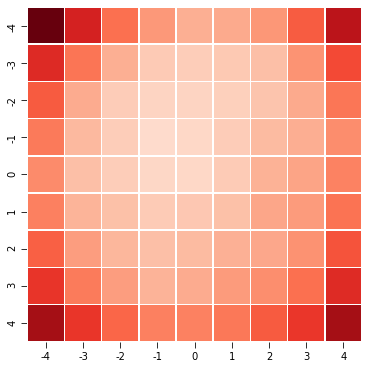

In [42]:
sb.heatmap(tmp_data_bok, annot=False, square=True,
           xticklabels=labels, yticklabels=labels,
           vmin=vmin, vmax=vmax, fmt=".2f", linewidths=.5, 
           cmap=sb_cmap_reds, cbar=False)

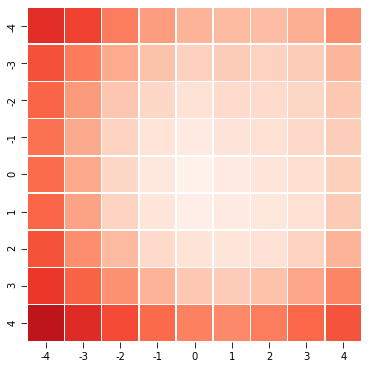

In [43]:
sb.heatmap(tmp_data_dans, annot=False, square=True,
           xticklabels=labels, yticklabels=labels,
           vmin=vmin, vmax=vmax, fmt=".2f", linewidths=.5,
           cmap=sb_cmap_reds, cbar=False)

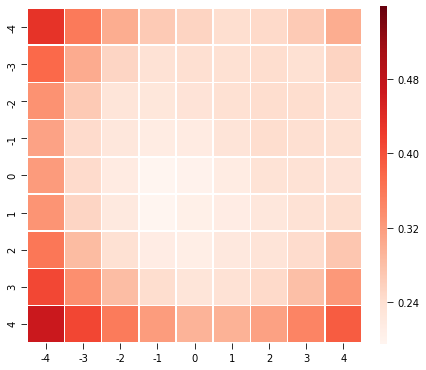

In [44]:
sb.heatmap(tmp_data_prop, annot=False, square=True,
               xticklabels=labels, yticklabels=labels,
               vmin=vmin, vmax=vmax, fmt=".2f", linewidths=.5,
               cmap=sb_cmap_reds, cbar=True,
               cbar_kws=dict(shrink=1.01, pad=0.04, aspect=45))